In [1]:
# -*- coding: utf-8 -*-
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import sys
sys.path.insert(0,'/Library/Frameworks/GDAL.framework/Versions/1.11/Python/2.7/site-packages')
sys.path.insert(0,'/usr/local/Cellar/opencv/2.4.13.2/lib/python2.7/site-packages')
from osgeo import gdal, osr, ogr
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(12345)
import scipy as sp
import os, math, random, re
%matplotlib inline

In [2]:
RASTER_FILE_PATH = 'images/2017'
RASTER_REGEX = re.compile(r'^2017-(?P<month>\d{2})-(?P<day>\d{2}).tif$')
def ReadBandArray(raster_filename, band_number=1):
    try:
        raster = gdal.Open(raster_filename)
        band = raster.GetRasterBand(band_number)
        return band.ReadAsArray()
    except Exception as e:
        print e
        print raster_filename, os.path.exist(raster_filename)

raster_filenames = []
for dirpath, dirnames, filenames in os.walk(RASTER_FILE_PATH):
    for filename in filenames:
        if re.match(RASTER_REGEX, filename):
            raster_filenames.append(os.path.join(dirpath, filename))

# 读取数据

In [3]:
fit_data = None
for filename in raster_filenames:
    a = ReadBandArray(filename).reshape(-1,1)
    if fit_data is None:
        fit_data = a
    else:
        fit_data = np.hstack((fit_data, a))


fit_data[np.isnan(fit_data)] = -1

fit_data.shape

(57792, 178)

# 原始影像的shape

In [4]:
original_shape = ReadBandArray("images/2017/2017-01-01.tif").shape
original_shape

(172, 336)

# k-Means聚类 n_clusters=8

In [5]:
from sklearn import  cluster
n_clusters=8
clst=cluster.KMeans(n_clusters=n_clusters)
clst.fit(fit_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# 查看结果 簇中心， 标记， 所有点距离簇中心的距离之和

In [6]:
clst.cluster_centers_, clst.labels_, clst.inertia_

(array([[ 0.17085307,  0.22456096,  0.22508702, ...,  0.33676073,
          0.31127913,  0.29155147],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [ 0.27983109,  0.40333856,  0.4070799 , ...,  0.36969767,
          0.2922142 ,  0.19751281],
        ..., 
        [ 0.23767159,  0.34148451,  0.34280871, ...,  0.36587445,
          0.29449713,  0.21148919],
        [ 0.13840528,  0.21088118,  0.21176456, ...,  0.4898221 ,
          0.4813599 ,  0.47281994],
        [ 0.19175822,  0.27341254,  0.27354399, ...,  0.35805819,
          0.29570279,  0.22988154]]),
 array([1, 1, 1, ..., 3, 3, 3], dtype=int32),
 30116.007221206808)

# 分类结果图像

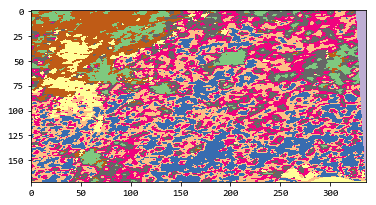

In [7]:
original_shape = ReadBandArray("images/2017/2017-01-01.tif").shape
result = clst.labels_.reshape(*original_shape)
import matplotlib
plt.imshow(result, cmap='Accent')
plt.savefig('/Users/mac/Desktop/kMeans-n_clusters=8.jpg', dpi=1000)

In [8]:
fit_data = np.stack((ReadBandArray(filename).reshape(*original_shape) for filename in raster_filenames), axis=0)

In [9]:
np.save('/Users/mac/Desktop/fit_data', fit_data)
np.save('/Users/mac/Desktop/result', result)

In [10]:
np.equal(result, 1).shape, fit_data.shape

((172, 336), (178, 172, 336))

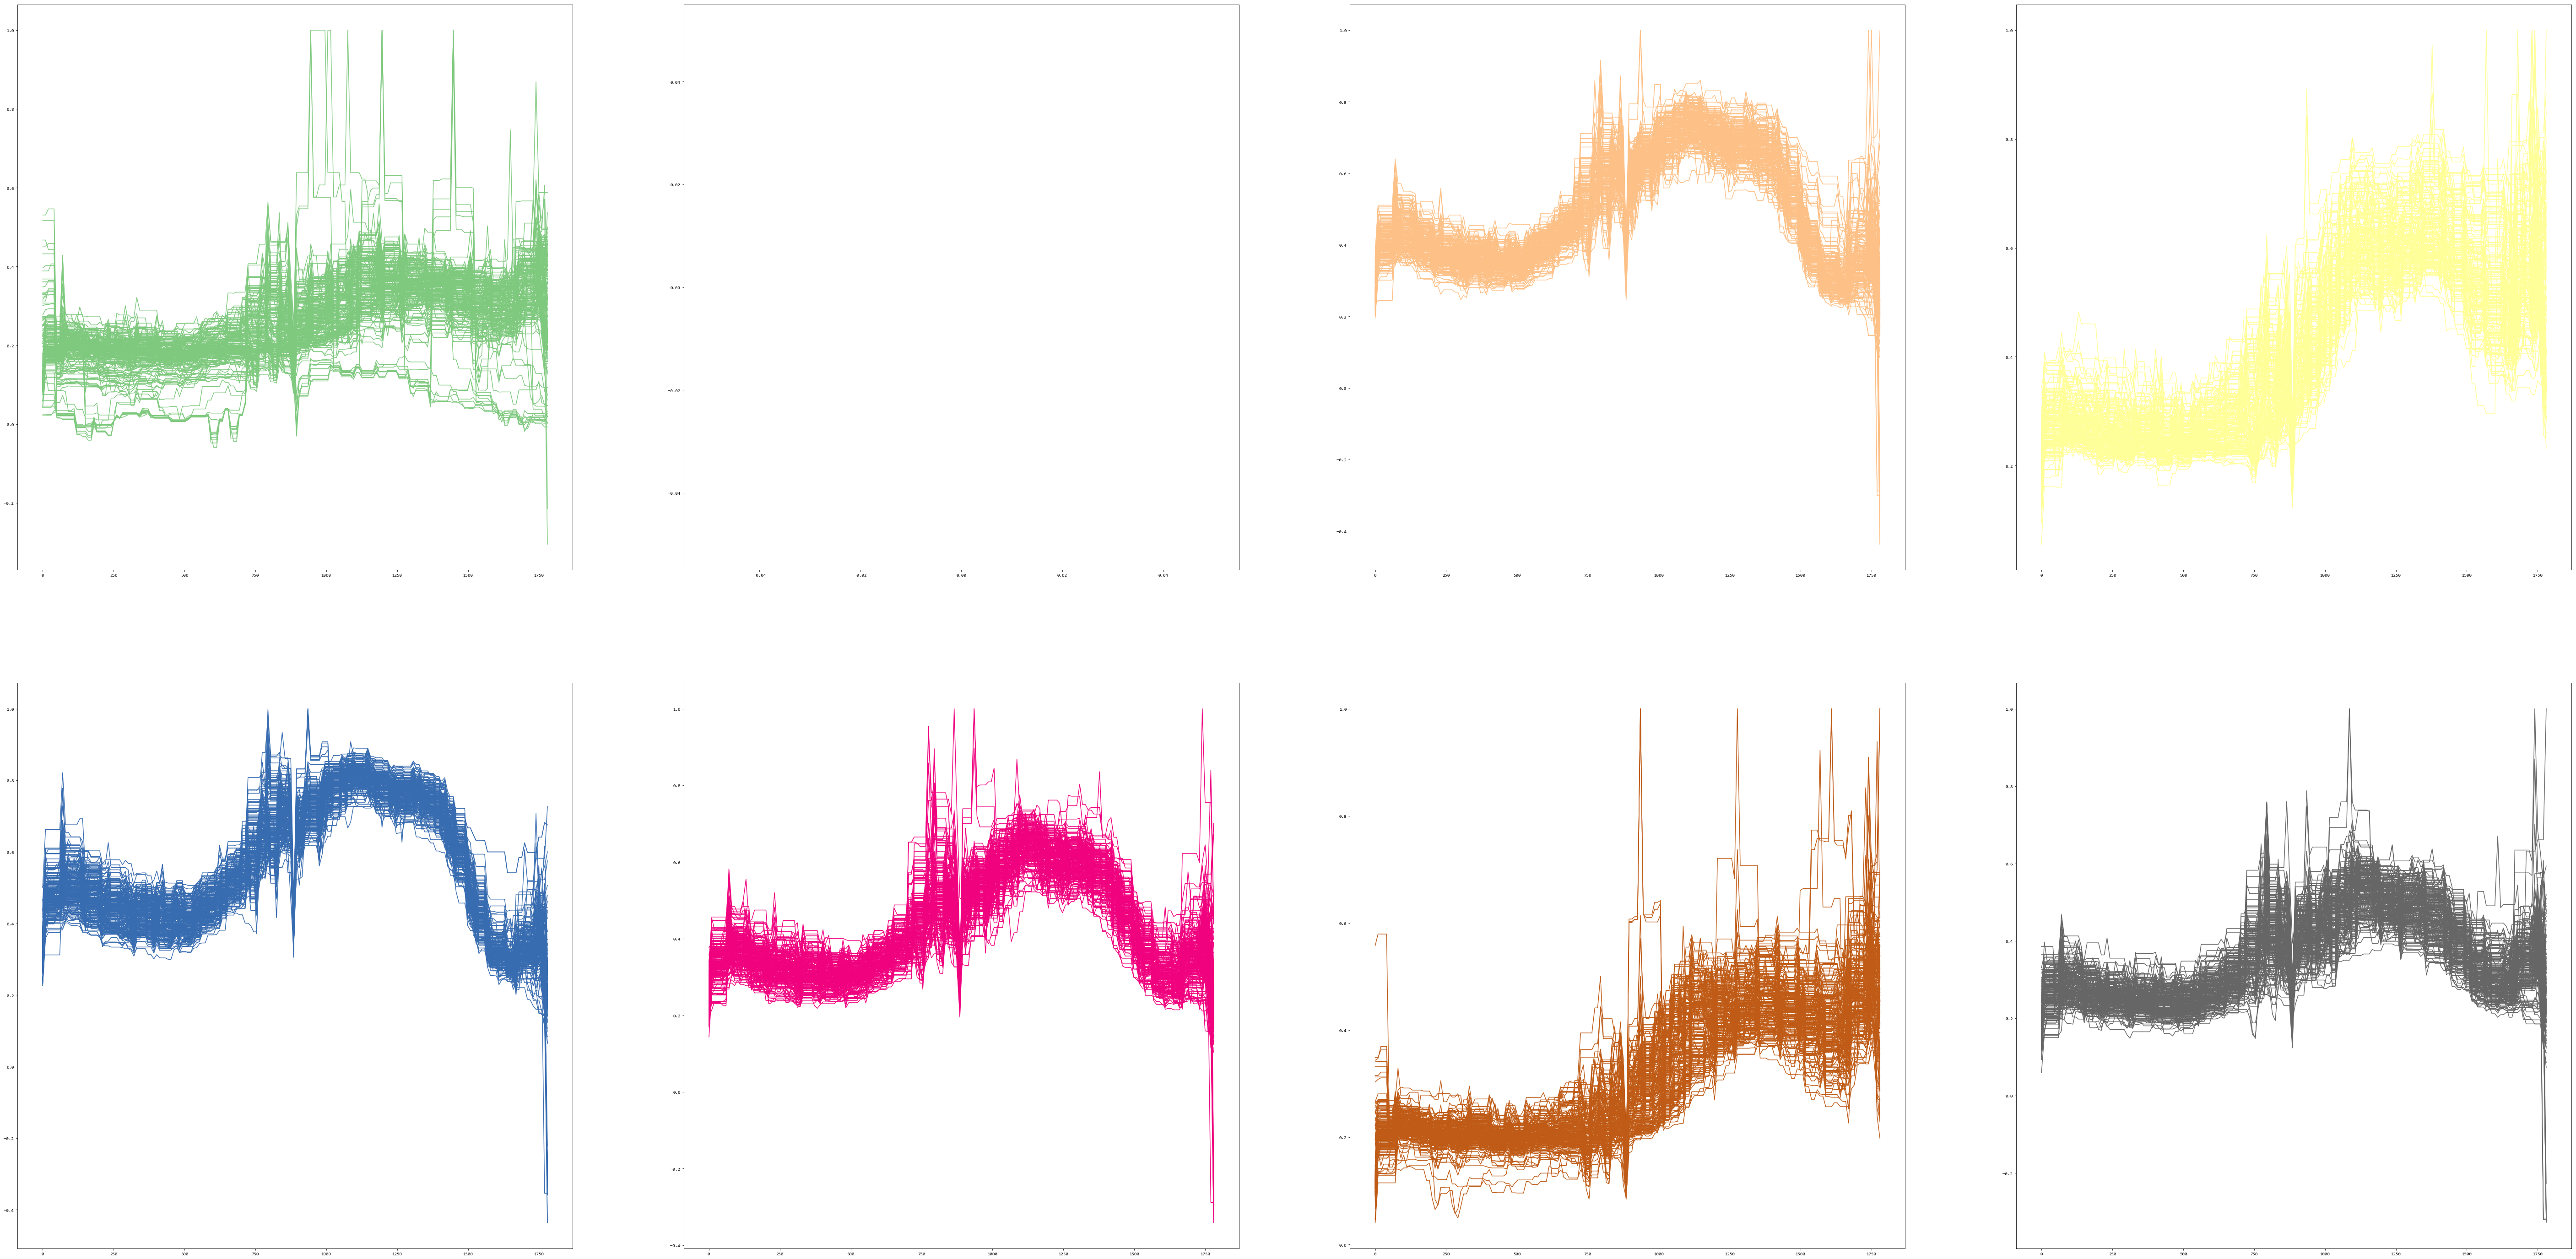

In [11]:
time_sequence = np.linspace(0,fit_data.shape[0]*10,fit_data.shape[0])
colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b16', '#666666']
plt.figure(figsize=(100, 50))
for i in range(n_clusters):
    plt.subplot(241+i)
    if fit_data[:,np.equal(result, i)].shape[1] > 200:
        random_index = np.random.choice(fit_data[:,np.equal(result, i)].shape[1], 200)
    else:
        random_index = np.arange(fit_data[:,np.equal(result, i)].shape[1])
    Y =  fit_data[:,np.equal(result, i)][:,random_index]
    for j in range(random_index.shape[0]):
        plt.plot(time_sequence, Y[:,j,],  colors[i], label=str(i))
    print j
plt.show()